In [1]:
# Standard libraries
import os
import tempfile
import time
import io
import random
import math
import warnings
from multiprocessing import Manager
from typing import Optional

# Data manipulation libraries
import numpy as np
import pandas as pd
import scipy

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset, random_split

# MONAI libraries
# from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.transforms import (
    AddChanneld, 
    CenterSpatialCropd, 
    Compose, 
    Lambdad, 
    LoadImaged, 
    Resized, 
    ScaleIntensityd
)
from monai.utils import set_determinism

# Other medical image processing libraries
import SimpleITK as sitk
import torchio as tio

# Plotting and visualization
import matplotlib.pyplot as plt

# Progress bar
from tqdm import tqdm

# Custom modules
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet_2Q
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
from dataloader import Train,Eval






config = {
    'batch_size': 1,
    'imgDimResize':(160,192,160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True, 
    'perc_low': 0, 
    'perc_high': 100,
    'rescaleFactor':2,
    'base_path': '',
}

# %%


imgpath = {}
csvpath_trains=['./combined.csv']
pathBase = '/scratch1/akrami/Data_train'
csvpath_val = './Data/splits/IXI_val_fold0.csv'
csvpath_test = './Data/splits/IXI_test.csv'
var_csv = {}
states = ['train','val','test']

df_list = []

# Loop through each CSV file path and read it into a DataFrame
for csvpath in csvpath_trains:
    df = pd.read_csv(csvpath)
    df_list.append(df)

# %%
var_csv['train'] =pd.concat(df_list, ignore_index=True)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test)
# if cfg.mode == 't2':
#     keep_t2 = pd.read_csv(cfg.path.IXI.keep_t2) # only keep t2 images that have a t1 counterpart

for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['norm_path'] =''
    var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
    var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    var_csv[state]['seg_path'] =  var_csv[state]['mask_path']


data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Eval(var_csv['test'],config)



#data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_test, batch_size=config.get('batch_size', 1),shuffle=False,num_workers=8)


device = torch.device("cuda")

2023-10-15 23:39:03,035 - A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


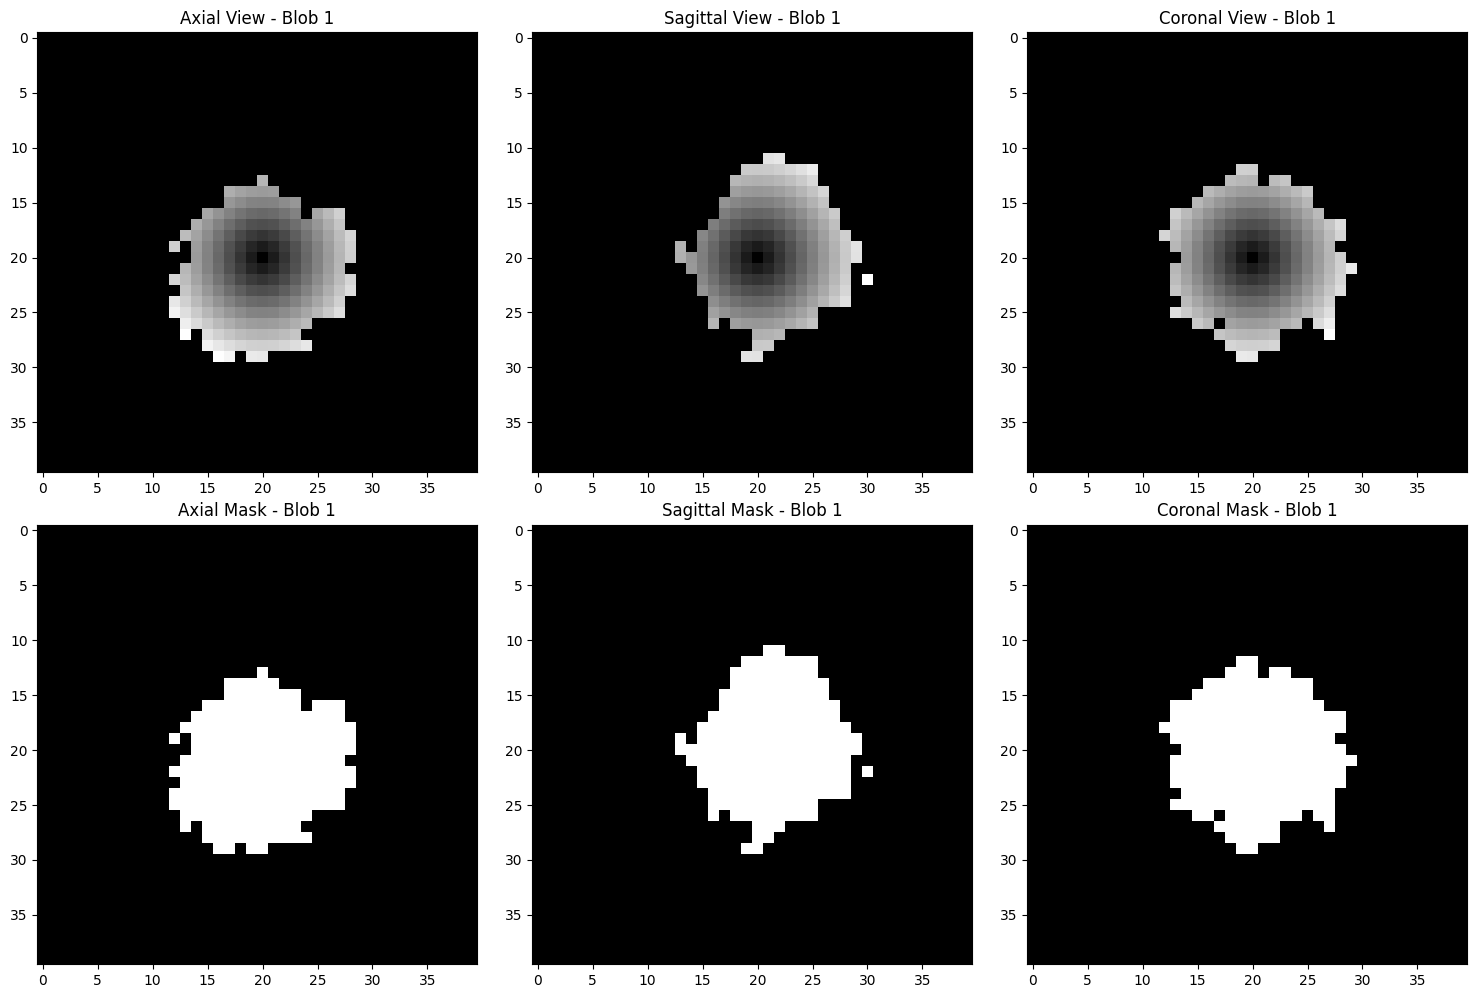

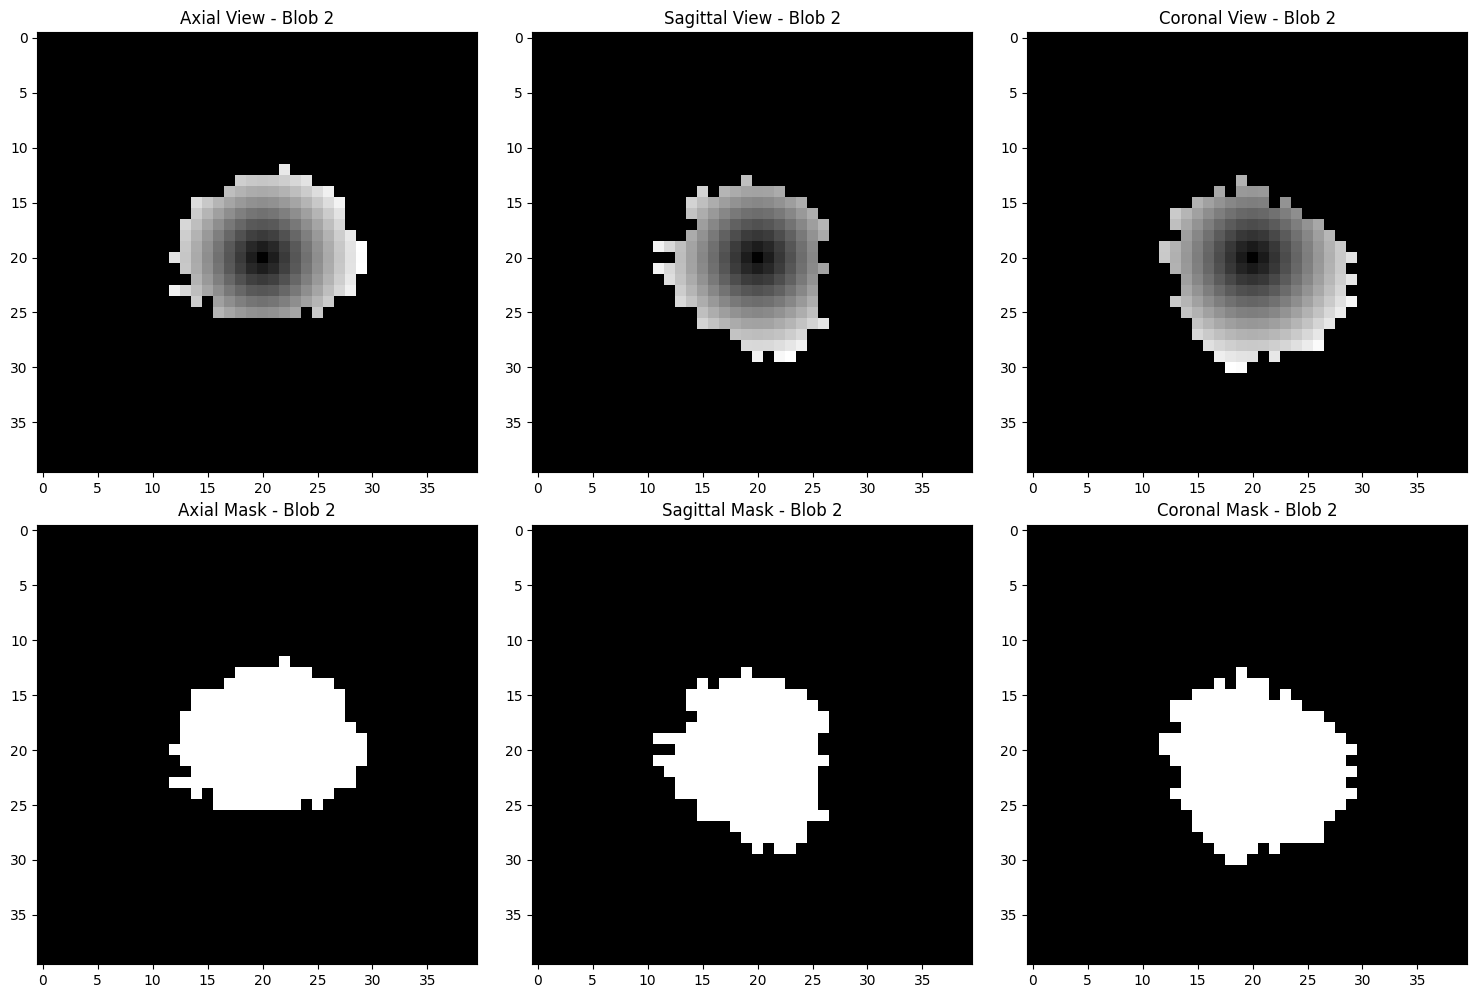

In [2]:
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage



def create_intensity_tensor(x_max, y_max, z_max):
    intensity_tensor = torch.zeros((x_max, y_max, z_max))
    center = torch.tensor([x_max // 2, y_max // 2, z_max // 2])
    
    for x in range(x_max):
        for y in range(y_max):
            for z in range(z_max):
                distance = torch.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
                max_distance = torch.sqrt(center[0]**2 + center[1]**2 + center[2]**2)
                intensity = 0.5 * ( distance / max_distance)+0.001
                intensity_tensor[x, y, z] = intensity.item()

    return intensity_tensor



def region_grow_3d_shape(x_max, y_max, z_max, num_growth_steps=4000):
    tensor = torch.zeros((x_max, y_max, z_max))
    intensity_tensor = create_intensity_tensor(x_max, y_max, z_max)

    # Start from the center
    x, y, z = x_max // 2, y_max // 2, z_max // 2
    tensor[x, y, z] = 1

    for _ in range(num_growth_steps):
        ones = (tensor == 1).nonzero(as_tuple=False)
        current_point = ones[random.randint(0, ones.shape[0] - 1)]
        
        moves = [[1, 0, 0], [-1, 0, 0], [0, 1, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1]]
        random.shuffle(moves)
        
        for move in moves:
            new_point = current_point + torch.tensor(move, dtype=torch.long)
            
            if (0 <= new_point[0] < x_max) and (0 <= new_point[1] < y_max) and (0 <= new_point[2] < z_max):
                if tensor[new_point[0], new_point[1], new_point[2]] == 0:
                    tensor[new_point[0], new_point[1], new_point[2]] = 1
                    break

    tensor *= intensity_tensor

    return tensor

# Generate and plot 
x_max, y_max, z_max = 40, 40, 40
tensor1 = region_grow_3d_shape(x_max, y_max, z_max)
tensor2 = region_grow_3d_shape(x_max, y_max, z_max)

size = (40, 40, 40)
for blob, title in zip([tensor1, tensor2], ["Blob 1", "Blob 2"]):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    axs[0, 0].imshow(blob[size[0] // 2, :, :], cmap='gray')
    axs[0, 0].set_title(f'Axial View - {title}')

    axs[0, 1].imshow(blob[:, :, size[2] // 2], cmap='gray')
    axs[0, 1].set_title(f'Sagittal View - {title}')

    axs[0, 2].imshow(blob[:, size[1] // 2, :], cmap='gray')
    axs[0, 2].set_title(f'Coronal View - {title}')

    mask = (blob > 0).float()
    axs[1, 0].imshow(mask[size[0] // 2, :, :], cmap='gray')
    axs[1, 0].set_title(f'Axial Mask - {title}')

    axs[1, 1].imshow(mask[:, :, size[2] // 2], cmap='gray')
    axs[1, 1].set_title(f'Sagittal Mask - {title}')

    axs[1, 2].imshow(mask[:, size[1] // 2, :], cmap='gray')
    axs[1, 2].set_title(f'Coronal Mask - {title}')

    plt.tight_layout()
    plt.show()


In [3]:
import numpy as np

def generate_gaussian_blob(size, sigma):
    """
    Generate a 3D Gaussian blob.
    
    Parameters:
    - size: a tuple of (depth, height, width) representing the size of the blob.
    - sigma: standard deviation for the Gaussian function.
    
    Returns:
    - A 3D numpy array representing the Gaussian blob.
    """
    z, y, x = np.meshgrid(np.linspace(-1,1,size[0]), np.linspace(-1,1,size[1]), np.linspace(-1,1,size[2]))
    d = np.sqrt(x*x + y*y + z*z)
    g = np.exp(-( (d)**2 / ( 2.0 * sigma**2 ) ))
    return g
    import torch

def random_lesion_params(image_shape):
    """
    Generate random lesion size and location based on the image shape.
    
    Parameters:
    - image_shape: a tuple of (channels, depth, height, width) representing the size of the image.
    
    Returns:
    - lesion_size: a tuple representing the size of the lesion.
    - start_location: a tuple representing the start location of the lesion in the image.
    """
    _, D, H, W = image_shape
    max_size = int(min(D, H, W)/2)
    
    lesion_depth =max( torch.randint(1, max_size + 1, (1,)).item(),20)
    lesion_height = max( torch.randint(1, max_size + 1, (1,)).item(),20)
    lesion_width = max( torch.randint(1, max_size + 1, (1,)).item(),20)
    
    lesion_size = (lesion_depth, lesion_height, lesion_width)
    
    start_d = torch.randint(0, D - lesion_depth + 1, (1,)).item()
    start_h = torch.randint(0, H - lesion_height + 1, (1,)).item()
    start_w = torch.randint(0, W - lesion_width + 1, (1,)).item()
    
    start_location = (start_d, start_h, start_w)
    
    return lesion_size, start_location


dict_keys(['vol', 'peak', 'seg', 'age', 'ID', 'path', 'mask'])
tensor([38.9000], dtype=torch.float64)


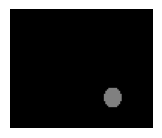

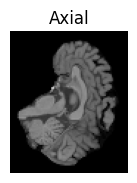

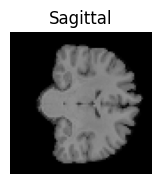

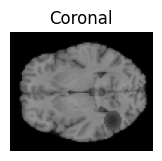

In [4]:
import copy

sub_test = next(iter(test_loader))
print(sub_test.keys())
print(sub_test['age'])


# Expand the dimensions of sub_test['peak'] to make it [1, 1, 1, 1, 4]
peak_expanded = (sub_test['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
# Move both tensors to the device
image_array = sub_test['vol']['data'].to(device)
brain_mask = copy.deepcopy(image_array)
brain_mask[brain_mask<=0.0002]=0
brain_mask[brain_mask>0.0002]=1


peak_expanded = peak_expanded.to(device)
image_array = (image_array / peak_expanded)
middle_slice_idx = image_array.size(-1) // 2
i=0
import copy

def check_tuple_equivalency(tuple1, tuple2):
    return all(torch.equal(a, b) for a, b in zip(tuple1, tuple2))

lesion_size, start_location = random_lesion_params(image_array[i].shape)


blob = generate_gaussian_blob(lesion_size, sigma=0.5)
threshold = 0.3
blob[blob < threshold] = 0
# Convert the blob (NumPy array) to a PyTorch tensor and move it to the same device as image_array
blob_tensor = torch.tensor(blob, device=image_array.device, dtype=image_array.dtype)
# Transpose the depth and height dimensions of the blob_tensor
blob_tensor = blob_tensor.permute(1, 0, 2)




blob_mask = copy.deepcopy(blob_tensor)
image_noisy = copy.deepcopy(image_array)

blob_mask[blob_mask>0]=1
blob_mask_non_zeros_ind = torch.where(blob_mask == 1)
# print(blob_mask_non_zeros_ind)
blb = (1-blob_tensor)*(blob_mask)
blb_mask_1 = 1 - blob_mask
blb_non_zeros_ind = torch.where(blb != 0)

# Add the blob_tensor to the image_array
val = (1-blob_tensor)*(blob_mask)+(image_array[i, 0, 
            start_location[0]:start_location[0]+lesion_size[0], 
            start_location[1]:start_location[1]+lesion_size[1], 
            start_location[2]:start_location[2]+lesion_size[2]])*(1-blob_mask)

image_array[i, 0,
            start_location[0]:start_location[0]+lesion_size[0], 
            start_location[1]:start_location[1]+lesion_size[1], 
            start_location[2]:start_location[2]+lesion_size[2]] = val

image_array = image_array*brain_mask
image_noisy = image_noisy*brain_mask
error = torch.abs(image_noisy-image_array)
error[error > 0.0] = 1

plt.figure(figsize=(2, 2))
plt.imshow(error[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()


def plot_3_views(image_tensor, i=0):
    """
    Plot three orthogonal views (axial, sagittal, and coronal) of a 3D tensor.
    
    Parameters:
    - image_tensor: a tensor of shape (batch_size, channels, depth, height, width)
    - i: index of the image in the batch to be visualized.
    """
    _, _, D, H, W = image_tensor.shape

    middle_slice_idx_d = D // 2
    middle_slice_idx_h = H // 2
    middle_slice_idx_w = W // 2

    # Axial View
    plt.figure(figsize=(2, 2))
    plt.imshow(image_tensor[i, 0, middle_slice_idx_d, :, :].detach().cpu().numpy(),vmin=0, vmax=2, cmap="gray")
    plt.tight_layout()
    plt.axis("off")
    plt.title("Axial")
    plt.show()

    # Sagittal View
    plt.figure(figsize=(2, 2))
    plt.imshow(image_tensor[i, 0, :, middle_slice_idx_h, :].detach().cpu().numpy(),vmin=0, vmax=2, cmap="gray")
    plt.tight_layout()
    plt.axis("off")
    plt.title("Sagittal")
    plt.show()

    # Coronal View
    plt.figure(figsize=(2, 2))
    plt.imshow(image_tensor[i, 0, :, :, middle_slice_idx_w].detach().cpu().numpy(), vmin=0, vmax=2,cmap="gray")
    plt.tight_layout()
    plt.axis("off")
    plt.title("Coronal")
    plt.show()


plot_3_views(image_array)



In [5]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Define your data directories and file paths
save_path_blobs = '/scratch1/akrami/sim_data'
csv_file_path = './blob.csv'
img_path = './sim_blob/'

# Create an empty DataFrame with the specified column names
data = {
    "idx": [],
    "ImageName": [],
    "blob_path": [],
    "snapshot_path": []
}
df = pd.DataFrame(data)

# Your test_loader and other code...

for step, batch in enumerate(test_loader):
    # Your existing code...
    images = batch['vol']['data'].to(device)
    brain_mask = copy.deepcopy(images)
    brain_mask[brain_mask<=0.02]=0
    brain_mask[brain_mask>0.02]=1
    img_name = batch['ID'][0]
    #print(images.shape)

    print(img_name)
    peak_expanded = (batch['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
    peak_expanded = peak_expanded.to(device)

    images = (images / peak_expanded)
    images_org = images.clone()
    
    # Generate a blob and check if it's placed entirely where the image is zero
    blob_valid = False
    while not blob_valid:
        lesion_size, start_location = random_lesion_params(images[i].shape)
        blob = generate_gaussian_blob(lesion_size, sigma=0.5)
        

        blob_tensor = torch.tensor(blob, device=image_array.device, dtype=image_array.dtype)
        blob_tensor = blob_tensor.to(device=images.device, dtype=images.dtype)
        blob_tensor = blob_tensor.permute(1, 0, 2)
        threshold = 0.1
        blob_tensor[blob_tensor < threshold] = 0
        assert blob_tensor.shape[:] == tuple(lesion_size), "Blob tensor shape doesn't match the lesion size."

        # Check if the blob is placed entirely where the image is zero
        region = images[0,0, 
                       start_location[0]:start_location[0]+lesion_size[0], 
                       start_location[1]:start_location[1]+lesion_size[1], 
                       start_location[2]:start_location[2]+lesion_size[2]]

        if torch.sum(region) != 0:
            blob_valid = True
        else:
            print(invalid)
        

    
    # Create a binary mask for the blob
    blob_mask = copy.deepcopy(blob_tensor)
    blob_mask[blob_mask > 0]=1

    


    images[0,0, 
      start_location[0]:start_location[0]+lesion_size[0], 
      start_location[1]:start_location[1]+lesion_size[1], 
      start_location[2]:start_location[2]+lesion_size[2]] = (1-blob_tensor)*(blob_mask)+(images[0, 0, 
            start_location[0]:start_location[0]+lesion_size[0], 
            start_location[1]:start_location[1]+lesion_size[1], 
            start_location[2]:start_location[2]+lesion_size[2]])*(1-blob_mask)
    
    # Clip the image to ensure minimum value is zero
    images = torch.clamp(images, min=0)

    print(images.shape)
    print(brain_mask.shape)
    images= brain_mask*images
    images_org = brain_mask*images_org
    # Rest of the code for saving and plotting
    padded_blob = torch.abs(images_org-images)
    blob_save_path = os.path.join(save_path_blobs, f"blob_{img_name}.pt")
    snapshot_save_path = os.path.join(img_path, f"snapshot_{img_name}.png")
    # blobshot_save_path = os.path.join(img_path, f"BLOB_{img_name}.png")
    
    torch.save(padded_blob, blob_save_path)
    #torch.save(padded_blob, blob_save_path)
    middle_slice = images[:,:,:,:, images.shape[4] // 2]
    
    plt.figure(figsize=(6,6))
    plt.imshow(middle_slice[0].cpu().numpy()[0], cmap='gray')
    plt.axis('off')
    plt.savefig(snapshot_save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    # Add data to the DataFrame
    df = df.append({
        "idx": step,
        "ImageName": img_name,
        "blob_path": blob_save_path,
        "snapshot_path": snapshot_save_path
    }, ignore_index=True)

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)


IXI105-HH-1471_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI019-Guys-0702_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI139-Guys-0815_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI406-Guys-0963_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI473-IOP-1137_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI579-Guys-1126_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI193-Guys-0810_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI370-Guys-0921_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI096-HH-1391_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI609-HH-2600_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI159-HH-1549_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI493-Guys-1007_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI216-HH-1635_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI276-HH-1840_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI121-Guys-0772_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI614-HH-2735_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI445-HH-2269_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI662-Guys-1120_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI453-HH-2214_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI451-HH-2212_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI485-HH-2180_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI338-HH-1971_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI299-Guys-0893_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI115-Guys-0738_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI116-Guys-0739_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI182-Guys-0792_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI086-Guys-0728_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI478-IOP-1142_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI588-IOP-1158_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI391-Guys-0934_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI598-HH-2606_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI544-HH-2395_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI396-HH-2115_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI492-Guys-1022_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI519-HH-2240_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI097-HH-1619_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI524-HH-2412_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI329-HH-1908_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI617-Guys-1090_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI632-HH-2652_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI587-Guys-1128_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI153-Guys-0782_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI408-Guys-0962_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI259-HH-1804_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI055-Guys-0730_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI202-HH-1526_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI084-Guys-0741_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI012-HH-1211_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI412-Guys-0949_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI490-Guys-1018_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI359-Guys-0918_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI185-Guys-0795_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI411-Guys-0959_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI639-Guys-1088_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI447-Guys-0979_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI486-Guys-1005_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI342-Guys-0909_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI120-Guys-0766_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI053-Guys-0727_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI578-Guys-1078_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI319-Guys-0901_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI439-HH-2114_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI462-IOP-1042_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI192-Guys-0878_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI566-HH-2535_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI208-Guys-0808_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI277-HH-1770_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI022-Guys-0701_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI437-HH-2152_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI206-HH-1650_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI179-Guys-0777_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI499-Guys-1004_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI531-Guys-1057_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI031-Guys-0797_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI030-Guys-0708_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI496-Guys-1045_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI353-HH-1996_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI348-Guys-0910_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI535-Guys-1061_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI383-HH-2099_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI229-Guys-0980_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI255-HH-1882_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI016-Guys-0697_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI575-HH-2658_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI219-Guys-0894_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI507-Guys-1036_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI267-HH-1772_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI635-HH-2691_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI494-Guys-1008_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI476-IOP-1140_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI164-Guys-0844_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI585-Guys-1130_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI486-Guys-1005_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI369-Guys-0924_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI549-Guys-1046_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI093-HH-1359_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI527-HH-2376_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI450-Guys-1093_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI146-HH-1389_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI150-HH-1550_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI595-IOP-1159_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI091-Guys-0762_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI162-HH-1548_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI039-HH-1261_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI218-HH-1815_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI242-HH-1722_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI205-HH-1649_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI169-Guys-0842_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI537-HH-2378_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI328-HH-2295_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI446-HH-2325_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI023-Guys-0699_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI469-IOP-1136_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI467-Guys-0983_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI157-Guys-0816_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI160-HH-1637_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI351-Guys-0914_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI199-Guys-0802_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI644-Guys-1121_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI038-Guys-0729_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI263-HH-1684_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI035-IOP-0873_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI512-Guys-1054_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI028-Guys-1038_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI488-Guys-1015_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI163-HH-1621_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI504-Guys-1025_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI567-HH-2536_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI098-Guys-0745_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI045-Guys-0713_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI264-Guys-0854_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI483-HH-2177_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI158-Guys-0783_t1.nii.gz


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI265-Guys-0845_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI427-IOP-1012_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI535-Guys-1061_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI563-IOP-1153_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI425-IOP-0988_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI518-HH-2239_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI354-HH-2024_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI515-HH-2377_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI344-Guys-0905_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI356-HH-2049_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI364-Guys-0920_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI573-IOP-1155_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI458-Guys-0993_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI552-Guys-1063_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI390-Guys-0931_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI621-Guys-1100_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI405-Guys-0948_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI237-Guys-1049_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI067-HH-1356_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI118-Guys-0764_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI413-Guys-0955_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI372-IOP-0971_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI367-Guys-0917_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


IXI195-HH-1620_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI328-HH-2295_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI449-Guys-1082_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])
IXI234-IOP-0870_t1.nii.gz
torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [6]:
# def adjusted_random_lesion_params(image_shape, min_lesion_fraction=0.25, max_lesion_fraction=0.5):
#     """
#     Generate random lesion size and location based on the image shape.
#     Ensure that the lesion size is between a minimum and maximum fraction of the image dimensions.
    
#     Parameters:
#     - image_shape: a tuple of (channels, depth, height, width) representing the size of the image.
#     - min_lesion_fraction: the minimum fraction of image dimensions for lesion size.
#     - max_lesion_fraction: the maximum fraction of image dimensions for lesion size.
    
#     Returns:
#     - lesion_size: a tuple representing the size of the lesion.
#     - start_location: a tuple representing the start location of the lesion in the image.
#     """
#     _, D, H, W = image_shape[1:]

#     min_lesion_depth = int(min_lesion_fraction * D)
#     max_lesion_depth = int(max_lesion_fraction * D)

#     min_lesion_height = int(min_lesion_fraction * H)
#     max_lesion_height = int(max_lesion_fraction * H)

#     min_lesion_width = int(min_lesion_fraction * W)
#     max_lesion_width = int(max_lesion_fraction * W)
    
#     lesion_depth = torch.randint(min_lesion_depth, max_lesion_depth + 1, (1,)).item()
#     lesion_height = torch.randint(min_lesion_height, max_lesion_height + 1, (1,)).item()
#     lesion_width = torch.randint(min_lesion_width, max_lesion_width + 1, (1,)).item()
    
#     lesion_size = (lesion_depth, lesion_height, lesion_width)

#     offset = 10  # Avoid lesions from being too close to the boundaries
#     start_d = torch.randint(offset, D - lesion_depth + 1 - offset, (1,)).item()
#     start_h = torch.randint(offset, H - lesion_height + 1 - offset, (1,)).item()
#     start_w = torch.randint(offset, W - lesion_width + 1 - offset, (1,)).item()

#     start_location = (start_d, start_h, start_w)

#     return lesion_size, start_location


In [7]:
# import os
# import torch
# import pandas as pd
# import matplotlib.pyplot as plt
# from PIL import Image
# import torchvision.transforms as transforms

# # Define your data directories and file paths
# save_path_blobs = '/scratch1/akrami/sim_data'
# csv_file_path = './blob.csv'
# img_path = './sim_blob/'

# # Create an empty DataFrame with the specified column names
# data = {
#     "idx": [],
#     "ImageName": [],
#     "blob_path": [],
#     "snapshot_path": []
# }
# df = pd.DataFrame(data)

# # Your test_loader and other code...

# for step, batch in enumerate(test_loader):
#     # Your existing code...
#     images = batch['vol']['data'].to(device)
#     img_name = batch['ID'][0]
#     #print(images.shape)

#     print(img_name)
#     peak_expanded = (batch['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
#     peak_expanded = peak_expanded.to(device)

#     images = (images / peak_expanded)
#     images_org = images.clone()
    
#     # Generate a blob and check if it's placed entirely where the image is zero
#     blob_valid = False
#     while not blob_valid:
#         lesion_size, start_location = adjusted_random_lesion_params(images.shape)
#         blob_tensor = region_grow_3d_shape(*lesion_size)

#         blob_tensor = blob_tensor.to(device=images.device, dtype=images.dtype)
#         assert blob_tensor.shape[:] == tuple(lesion_size), "Blob tensor shape doesn't match the lesion size."

#         # Check if the blob is placed entirely where the image is zero
#         region = images[0,0, 
#                        start_location[0]:start_location[0]+lesion_size[0], 
#                        start_location[1]:start_location[1]+lesion_size[1], 
#                        start_location[2]:start_location[2]+lesion_size[2]]

#         if torch.sum(region) != 0:
#             blob_valid = True
#         else:
#             print(invalid)
           

#     # Create a binary mask for the blob
#     blob_mask = blob_tensor > 0

#     # Replace original image values with the blob values using the binary mask
#     images[0,0, 
#       start_location[0]:start_location[0]+lesion_size[0], 
#       start_location[1]:start_location[1]+lesion_size[1], 
#       start_location[2]:start_location[2]+lesion_size[2]] = images[0,0, 
#                                                                       start_location[0]:start_location[0]+lesion_size[0], 
#                                                                       start_location[1]:start_location[1]+lesion_size[1], 
#                                                                       start_location[2]:start_location[2]+lesion_size[2]] * (1 - blob_mask.float()) + blob_tensor * blob_mask.float()
    
#     # Clip the image to ensure minimum value is zero
#     images = torch.clamp(images, min=0)

#     # Rest of the code for saving and plotting
#     padded_blob = images_org-images
#     blob_save_path = os.path.join(save_path_blobs, f"blob_{img_name}.pt")
#     snapshot_save_path = os.path.join(img_path, f"snapshot_{img_name}.png")
#     blobshot_save_path = os.path.join(img_path, f"BLOB_{img_name}.png")
    
#     torch.save(padded_blob, blob_save_path)
#     #torch.save(padded_blob, blob_save_path)
#     middle_slice = images[:,:,:,:, images.shape[4] // 2]
    
#     plt.figure(figsize=(6,6))
#     plt.imshow(middle_slice[0].cpu().numpy()[0], cmap='gray')
#     plt.axis('off')
#     plt.savefig(snapshot_save_path, bbox_inches='tight', pad_inches=0)
#     plt.close()

#     # Add data to the DataFrame
#     df = df.append({
#         "idx": step,
#         "ImageName": img_name,
#         "blob_path": blob_save_path,
#         "snapshot_path": snapshot_save_path
#     }, ignore_index=True)

# # Save the DataFrame to a CSV file
# df.to_csv(csv_file_path, index=False)


In [8]:
import pandas as pd
csv_file_path = './blob.csv'
# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Set the "ImageName" column as the index
df.set_index('ImageName', inplace=True)

# Optionally, you can save the updated DataFrame to a new CSV file
df.to_csv('blob_csv_file.csv')


In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Load the CSV into a DataFrame
df = pd.read_csv(csv_file_path)

# Set the 'ImageName' column as the index
df.set_index('ImageName', inplace=True)

# Define the directory to save the plots
save_dir = './sim_blob/'

# Loop through the images again
for step, batch in enumerate(test_loader):
    img_name = batch['ID'][0]  # Assuming img_name is a list and you want the first element
    #print(img_name)
    
    # Retrieve the blob path based on the 'ID'
    blob_path = df.loc[img_name, 'blob_path'] if img_name in df.index else None
    #print (blob_path)

    print(blob_path)
    if blob_path:
        # Load the blob
        blob_tensor = torch.load(blob_path)
        #print(blob_tensor.unique())
         # Create a mask where blob_tensor is not zero
        mask = (blob_tensor> 0.0).float()
        #print(mask.unique())
        
        # Take the middle slice of the mask
        middle_slice = mask[0, 0,:, :, blob_tensor.shape[4] // 2]
        
        # Plot and save the middle slice
        plt.figure(figsize=(6, 6))
        plt.imshow(middle_slice.cpu().numpy(), cmap='gray')
        plt.axis('off')
        
        # Define the file path to save the plot
        blob_save_path = f'{save_dir}/{img_name}_mask.png'
        
        # Save the plot
        plt.savefig(blob_save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    else:
        print(f"No blob found for image ID: {img_name}")
        
       
    
    

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# import random

# def generate_gaussian_blob(size, sigma, deformation_factor, randomness_factor=0.0):
#     z, y, x = np.meshgrid(np.linspace(-1, 1, size[0]), np.linspace(-1, 1, size[1]), np.linspace(-1, 1, size[2]))

#     # Randomly perturb the deformation equations with noise
    
#     x_deformed = x + deformation_factor * np.sin(2 * np.pi * x) 
#     y_deformed = y + deformation_factor * np.cos(2 * np.pi * y)

#     # Compute the distance and Gaussian blob with deformed coordinates
#     d = np.sqrt(x_deformed**2 + y_deformed**2 + z**2)
#     g = np.exp(-(d**2 / (2.0 * sigma**2)))

#     # Threshold the blob to mask all non-zero values
#     threshold = 0.01  # Adjust this threshold as needed
#     masked_blob = np.where(g < threshold, 0, g)

#     return masked_blob

# # Example usage:
# size = (64, 64, 64)
# sigma = 0.2  # Adjust this value as needed
# randomness_factor = 0.05  # Adjust this value to control the noise
# deformation_factor_1 = 0.2

# # Generate the blob
# blob = generate_gaussian_blob(size, sigma, deformation_factor_1, randomness_factor)

# # Create ScalarMappable objects for the colormaps
# cmap = plt.get_cmap('gray')
# norm = mcolors.Normalize(vmin=0, vmax=1)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])

# # Visualize the blob with random view orientation
# orientations = [(size[0] // 2, "Axial"), (size[1] // 2, "Sagittal"), (size[2] // 2, "Coronal")]
# random.shuffle(orientations)

# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# for idx, (slice_index, orientation) in enumerate(orientations):
#     if orientation == "Axial":
#         axs[idx].imshow(blob[slice_index, :, :], cmap='gray')
#     elif orientation == "Sagittal":
#         axs[idx].imshow(blob[:, :, slice_index], cmap='gray')
#     else:  # "Coronal"
#         axs[idx].imshow(blob[:, slice_index, :], cmap='gray')
#     axs[idx].set_title(f'{orientation} View - Blob')

# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(sm, cax=cbar_ax)
# plt.show()
